<a href="https://colab.research.google.com/github/nabinyd/60-Days-of-learning/blob/main/DLPT_05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch Custom Datasets
# Day 23

  ##  0. Importing PyToch and setting up device-agnostic code
  

In [19]:
import torch
from torch import nn

torch.__version__

'2.3.0+cu121'

In [20]:
#  Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cpu'

## 1. Get data

our dataset is a subset of the Food101 dataset.

Food101 starts 101 different classes of food and 1000 images per class (750 training, 250 testing)

Our dataset starts with classes of food and only 10% of the images. (~75 training, 25  testing).

Why do this?

When starting out ML projects, it's important to try things on a small scale and then increase the scale when necessary.


In [21]:
import requests
import zipfile
from pathlib import Path

# Setup path to a data folder
data_path = Path("data/")
image_path = data_path / "pizaa_steak_sushi"

# If the image folder doesnt exist, download it and prepare it...
if image_path.is_dir():
  print(f"{image_path} directory a;ready exists... skipping download")
else:
  print(f"{image_path} does not exist, creating one...")
  image_path.mkdir(parents=True, exist_ok=True)

  # Downlaod pizza, steak and sushi data
  with open(data_path / "pizza_steak_sushi.zip","wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downlooading pizza, steak, sushi data...")
    f.write(request.content)

data/pizaa_steak_sushi directory a;ready exists... skipping download


In [22]:
# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
  print("Unzipping pizza, steak and sushi data..")
  zip_ref.extractall(image_path)

Unzipping pizza, steak and sushi data..


## 2. Becoming one with the data (data preparation and data exploration)

In [23]:
import os
def walK_through_dir(dir_path):
  """Walks through dir_path returning its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'. ")

In [24]:
walK_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizaa_steak_sushi'. 
There are 3 directories and 0 images in 'data/pizaa_steak_sushi/train'. 
There are 0 directories and 75 images in 'data/pizaa_steak_sushi/train/steak'. 
There are 0 directories and 78 images in 'data/pizaa_steak_sushi/train/pizza'. 
There are 0 directories and 72 images in 'data/pizaa_steak_sushi/train/sushi'. 
There are 3 directories and 0 images in 'data/pizaa_steak_sushi/test'. 
There are 0 directories and 19 images in 'data/pizaa_steak_sushi/test/steak'. 
There are 0 directories and 25 images in 'data/pizaa_steak_sushi/test/pizza'. 
There are 0 directories and 31 images in 'data/pizaa_steak_sushi/test/sushi'. 


In [25]:
#  Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"


train_dir, test_dir

(PosixPath('data/pizaa_steak_sushi/train'),
 PosixPath('data/pizaa_steak_sushi/test'))

 ### 2.1 Visualizing and image

 Let's write some code to:
 1. Get all of the ransom paths
 2. Pick a random image path using Python's random.choice()
 3. Get the image class name using `pathlib.Path.parent.stem`
 4. Since we're working with images, let's open the image with Python's PIL

 5. We'll then show the image and print metadata

data/pizaa_steak_sushi/train/pizza/1649276.jpg
pizza
Random image path: data/pizaa_steak_sushi/train/pizza/1649276.jpg
Image class: pizza
Image height: 384
Image width: 512


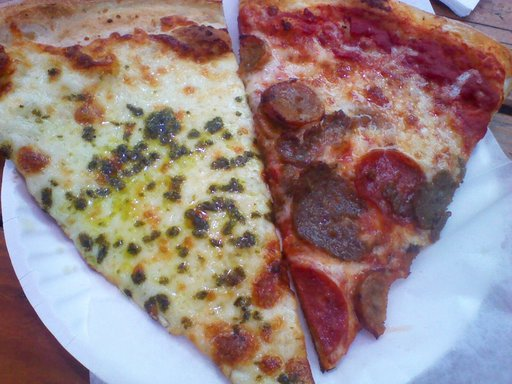

In [26]:
import random
from PIL import Image

# Set seed
# random.seed(42)

# 1. Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)
print(random_image_path)

# 3. Get image class form path name (the image class is the name of the directroy where the image the image is stored)
image_class = random_image_path.parent.stem
print(image_class)

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")

img



In [27]:
# image_path_list

(-0.5, 511.5, 383.5, -0.5)

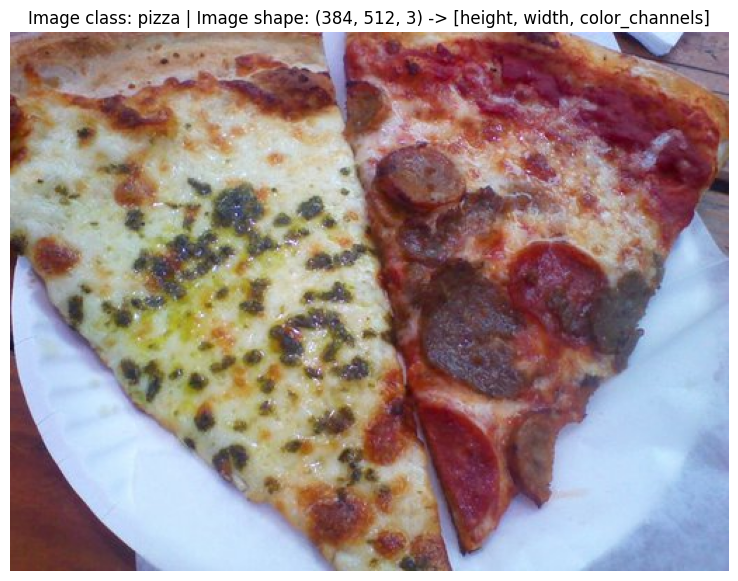

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False)

# Day 24

## 3. Transforming data

Before we can use our image idata with pytorch:
1. Turn your target data into tensors (in our case, numerical representation of our images).

2. Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`, we'll call these `dataset` and `dataloader`



In [29]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Transforming data with `torchvision.transforms`

In [30]:
# write a transform for image
data_transform = transforms.Compose([
    # Resize our images to 64x64
    transforms.Resize(size=(64,64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn the image into a torch.Tensor
    transforms.ToTensor()
  ])

In [31]:
data_transform(img)

tensor([[[0.5686, 0.5451, 0.4902,  ..., 0.5725, 0.5843, 0.5804],
         [0.5529, 0.5294, 0.5098,  ..., 0.5725, 0.5882, 0.6039],
         [0.5529, 0.5020, 0.5294,  ..., 0.5137, 0.5569, 0.6000],
         ...,
         [0.5216, 0.5098, 0.5216,  ..., 0.3961, 0.3961, 0.4039],
         [0.5333, 0.5216, 0.5255,  ..., 0.4000, 0.4078, 0.4118],
         [0.5255, 0.5137, 0.5176,  ..., 0.4000, 0.4118, 0.4196]],

        [[0.4863, 0.4706, 0.4353,  ..., 0.4431, 0.4824, 0.4824],
         [0.4902, 0.4745, 0.4510,  ..., 0.3961, 0.4157, 0.4588],
         [0.4824, 0.4549, 0.4706,  ..., 0.3137, 0.3569, 0.4314],
         ...,
         [0.6235, 0.6275, 0.6353,  ..., 0.2000, 0.2000, 0.2039],
         [0.6353, 0.6235, 0.6196,  ..., 0.2039, 0.2039, 0.2078],
         [0.6157, 0.6196, 0.6235,  ..., 0.2000, 0.2000, 0.2039]],

        [[0.5608, 0.5529, 0.5255,  ..., 0.4431, 0.5255, 0.5569],
         [0.5529, 0.5529, 0.5373,  ..., 0.3098, 0.3647, 0.4353],
         [0.5490, 0.5294, 0.5412,  ..., 0.2392, 0.2824, 0.

In [32]:
data_transform(img).shape
data_transform(img).dtype

torch.float32

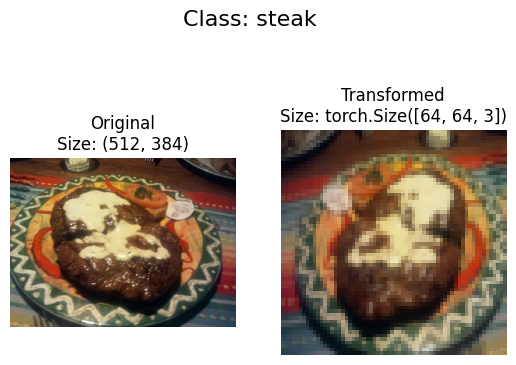

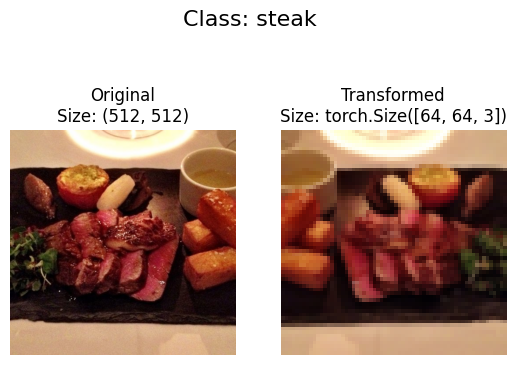

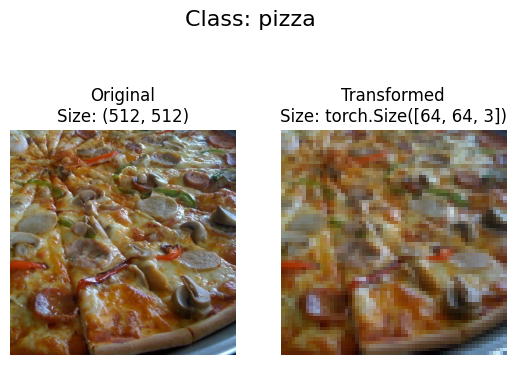

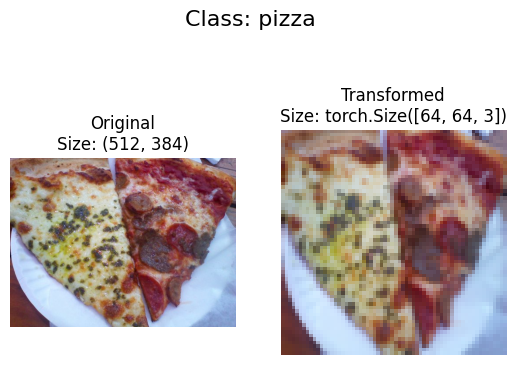

In [35]:
def plot_transformed_images(image_paths,transform, n=3, seed=None):
  """
  Selects random images form a path of images and loads/ transforms them then plots the original vs the transformed version.
  """
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)

      # Transform and plot target image
      transformed_image = transform(f).permute(1,2,0)    # note we will need to change shape for matplotlib (C, H, W) => (H,W,C)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nSize: {transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)



plot_transformed_images(image_paths=image_path_list,
                        transform=data_transform,
                        n=4,
                        seed=42)



## 4. Option 1: Loading image data using  `ImageFolder`

We can load imag eclassification data using `torchvision.darasets.ImageFolder`

In [36]:
# Use ImageFolder to create dataset(s)

from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,    # a transform for the data
                                  target_transform=None)     # a transformfor the label/target
test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizaa_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizaa_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

### Dataset Details:

1. **Training Dataset**:
    * Number of datapoints:255
    * Root location: `data/pizza_steak_sushi/train`
    * Transformations:
      * Resize: Images are resized to (64,64) pixels
      * RandomHorizontalFlip: Randomly flips the image horizontally with a probability of 0.5
      * ToTensor: Converts the image to a PyTorch tensor.

2. **Testing dataset**:
    * Number of datapints: 75
    * Root location: `data/pizza_steak_sushi/test`
    * Transformations:
       * Resize: Images are resized to (64 , 64) pixels.
       * RandomHorizontalFlip: Randomly flips the image horizonally with a probability of 0.5
       * ToTensor: Converts the image to PyTorch tensor


**Explanation :**

*  `ImageFolder`: This is a dataset class provided by `torchvision` that loads images from a directory. Each subdirectory in the root location to a class label.

*  `Transforms`:
  * `resize`: Ensures that all imafes have the same size, which is important for batching and feeding into the neural network.

  * `RandomHorizontalFlip`: This is a data augmentation technnique. By flipping the images horizontally at random, model is exposed to different variations of the training images, which can help improve generalization.

  * `ToTensor`: Converts the PIL Image or numpy.ndarray into a tensor, which is the format required by PyTorch for training and testing.



  ** Why use these Transforms?**
  *  **Resize**: Standardizes the input size, which simplifies the model architecture and training process.

  * **RandomHorizontalFlip**: Augments the dataset to include flipped versions of the images, making the model more robust to variations.

  * **ToTensor**: Converts images into a format suitable for PyTorch operations and neural network computations


By applying these transformations, the dataset becomes more manageable and suitable for training a neural network, as it ensures consistency in input size and introduces variability to improve model robustness.

In [37]:
# Get class names as list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [38]:
 class_dict = train_data.class_to_idx
 class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [39]:
# Check the length of our dataset
len(train_data), len(test_data)

(225, 75)